<a href="https://colab.research.google.com/github/sanusi009/Newproject/blob/main/Solution_to_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load the dataset**: The dataset is loaded using Python's pickle module. Training and test sets for both features (x_train, x_test) and target labels (y_train, y_test) are included in the dictionary containing the data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
with open('california-housing-dataset.pkl', 'rb') as f:
    Califo_data = pickle.load(f)
x_train, y_train =  Califo_data['x_train'],  Califo_data['y_train']
x_test, y_test =  Califo_data['x_test'],  Califo_data['y_test']

**Make a validation set**: 20% of the training data is used for validation, while the remaining 80% is used for actual training. Without affecting the test set, which is solely utilized for final evaluation, this aids in evaluating model performance throughout training. The train_test_split function from sklearn is used for this.

In [3]:
import sys

assert sys.version_info >= (3, 7)

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

**Examine feature distributions**: To see how the features are distributed, we employ histograms. This makes it easier to determine which characteristics—like income or population—need to be normalized. Prior to applying normalization, visualizing the data guarantees that we comprehend its properties.

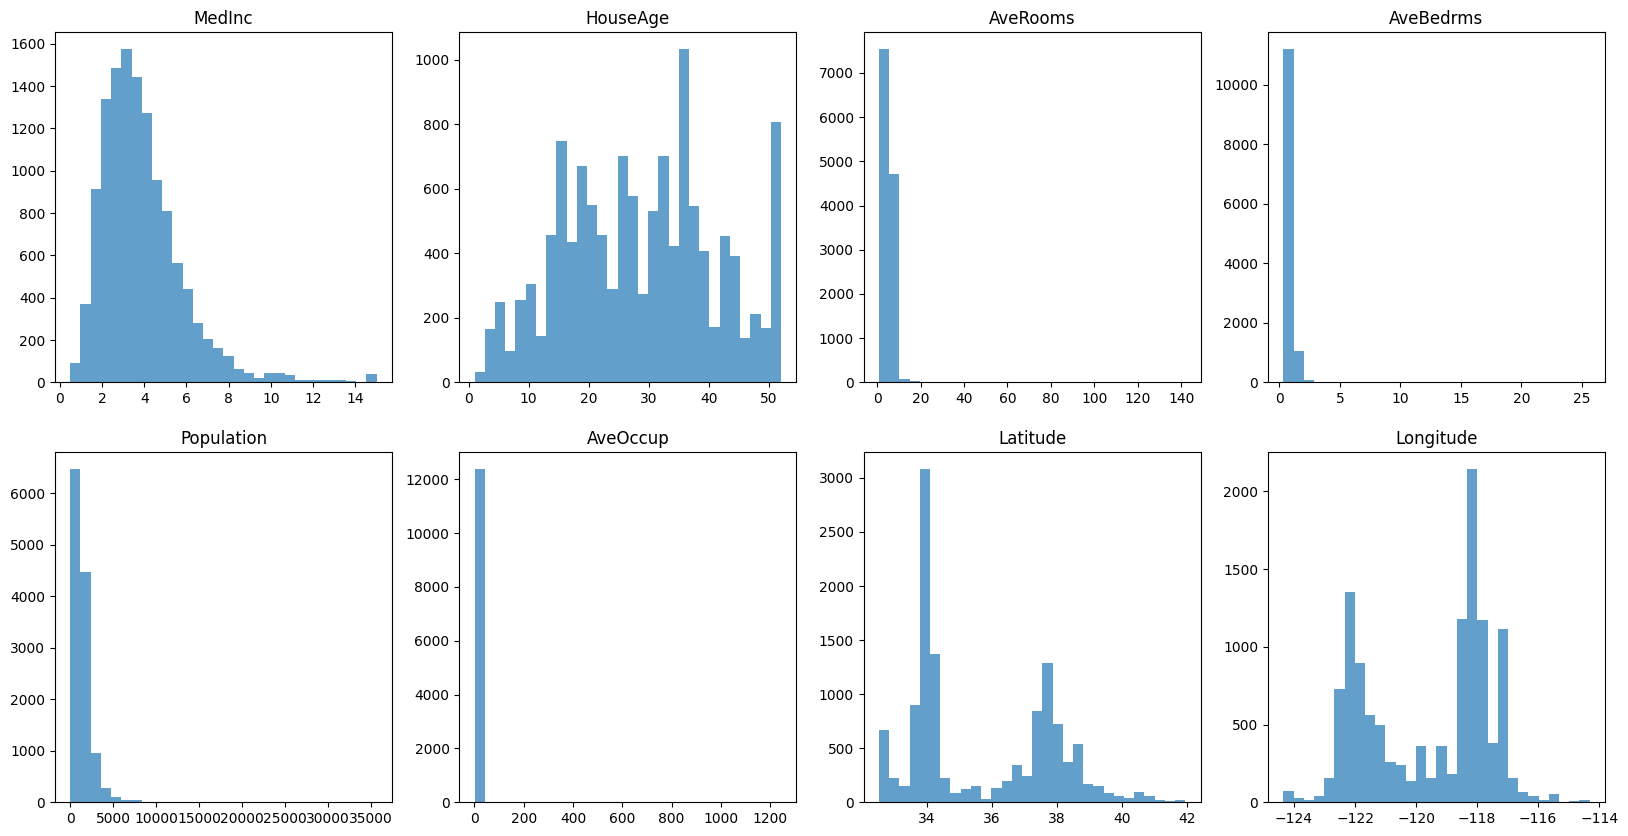

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, feature in enumerate(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']):
    axs[i//4, i%4].hist(x_train[:, i], bins=30, alpha=0.7)
    axs[i//4, i%4].set_title(feature)
plt.show()

**Find and Display the Data to Get Knowledge**

In [7]:
from pathlib import Path

In [8]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Geographic Data Visualization**

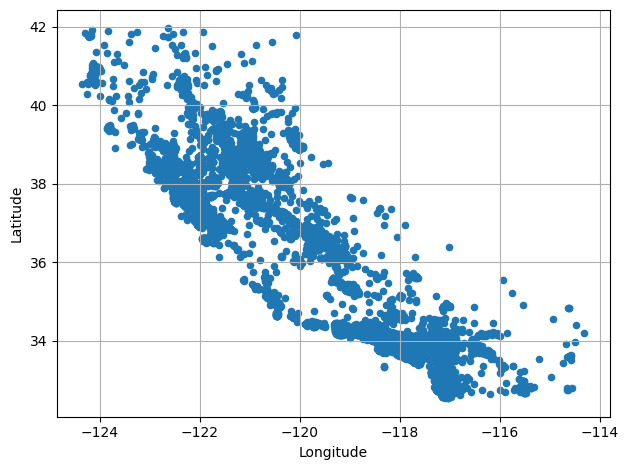

In [9]:
import pandas as pd

x_train_df = pd.DataFrame(x_train, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])

x_train_df.plot(kind="scatter", x="Longitude", y="Latitude", grid=True) # Use 'Longitude' and 'Latitude', matching the DataFrame column names
save_fig("bad_visualization_plot")
plt.show()

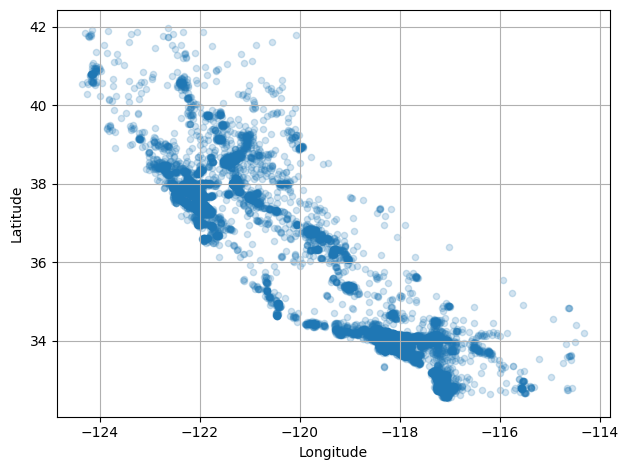

In [10]:
x_train_df.plot(kind="scatter", x="Longitude", y="Latitude",grid=True, alpha=0.2)
save_fig("bad_visualization_plot")
plt.show()

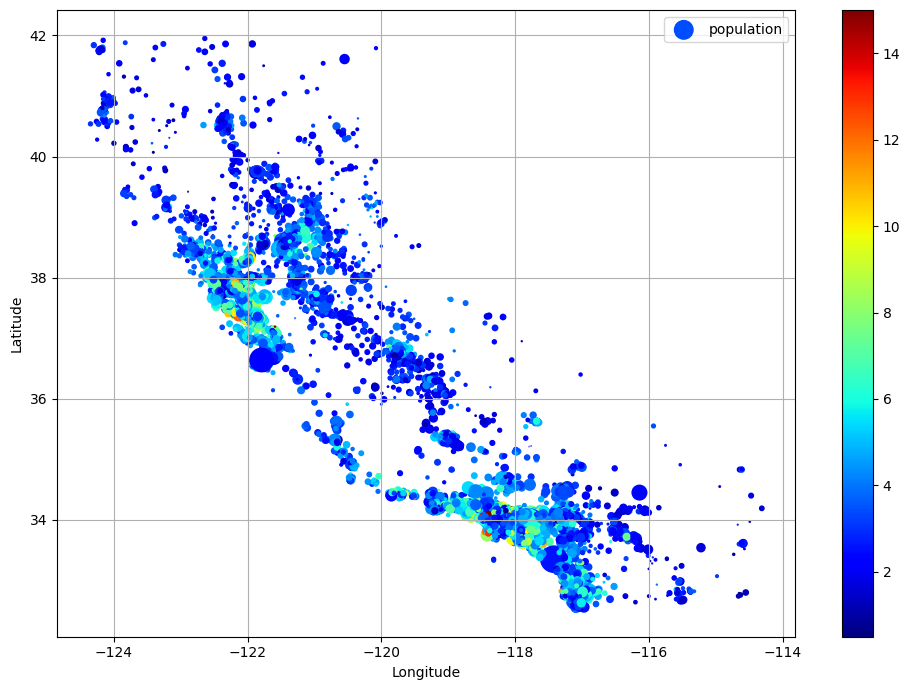

In [11]:
x_train_df.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
           s=x_train_df["Population"] / 100, label="population",
           c=x_train_df["MedInc"], cmap="jet", colorbar=True, # Changed "median_house_value" to x_train_df["median_house_value"]
           legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

**Normalize the data**: When the data is scaled or normalized, neural networks typically perform better. Training is made faster and more stable by the StandardScaler, which scales features to have zero mean and unit variance.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

**Neural Network Design**

**Neural network architecture**: Layers of neurons make up a neural network. Since we are predicting a single continuous value, regression requires an output layer with one unit and a linear output without an activation function. Since ReLU activation is straightforward and effective for the majority of applications, we apply it in the hidden layers.

In [13]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def building_model(hidden_layers, hidden_units, input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))  # Define input shape using Input layer
    model.add(Dense(hidden_units, activation='relu'))  # First hidden layer

    for _ in range(hidden_layers - 1):  # Add more hidden layers if needed
        model.add(Dense(hidden_units, activation='relu'))

    # Output layer (1 unit for regression)
    model.add(Dense(1))

    # Compile model with Adam optimizer, mean squared error loss
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


I examine several designs with different numbers of neurons and hidden layers (e.g., one, two, and three hidden layers with 64, 128, and 256 neurons correspondingly). Every architecture undergoes 20 training epochs, during which the validation loss is monitored.

In [15]:
architectures = [
    {'hidden_layers': 1, 'hidden_units': 64},
    {'hidden_layers': 2, 'hidden_units': 128},
    {'hidden_layers': 3, 'hidden_units': 256},
]

for arch in architectures:
    model = building_model(arch['hidden_layers'], arch['hidden_units'], x_train.shape[1])
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, verbose=0)
    print(f"Architecture {arch}: Final Val Loss = {history.history['val_loss'][-1]}")


Architecture {'hidden_layers': 1, 'hidden_units': 64}: Final Val Loss = 0.32174360752105713
Architecture {'hidden_layers': 2, 'hidden_units': 128}: Final Val Loss = 0.26931673288345337
Architecture {'hidden_layers': 3, 'hidden_units': 256}: Final Val Loss = 0.25106924772262573


**Metrics:**
**Loss**: Because this is a regression problem, mean squared error, or MSE, is used. Larger errors are penalized more harshly by MSE than smaller ones.
**Metrics:** To determine the average discrepancy between expected and actual data, we also monitor Mean Absolute Error (MAE).


**Hyperparameters and Optimizers**

Examine the effects of varying learning rates and optimization strategies on model performance.




**Optimization algorithms**: The model's ability to optimize weights has a significant impact on its performance. I test out:

***SGD with momentum***: This helps accelerate convergence by considering the
past gradients.

***SGD (Stochastic Gradient Descent)***: Standard gradient descent.

***Adam***: Adaptive learning rate method that often works well out of the box.

In [16]:
from tensorflow.keras.optimizers import SGD, Adam

def testing_optimizers(model, optimizers, learning_rates):
    results = []
    for opt in optimizers:
        for lr in learning_rates:
            # Check if the optimizer is a class or a function
            if callable(opt):
                # If it's a function (like your lambda function), call it with learning_rate as an argument
                # If it's a function, but returns a class, you still need to use learning_rate
                # The lambda function expects a positional argument, not a keyword argument
                optimizer_instance = opt(lr)  # Changed here: Pass lr as a positional argument
            else:
                # If it's a class (like Adam or SGD), instantiate it with learning_rate as a keyword argument
                optimizer_instance = opt(learning_rate=lr)

            model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
            history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, verbose=0)
            results.append((str(opt), lr, history.history['val_loss'][-1], history.history['val_mae'][-1]))
    return results

# Define optimizers and learning rates to test
optimizers = [Adam, SGD, lambda lr: SGD(learning_rate=lr, momentum=0.9)]
learning_rates = [0.01, 0.001, 0.0001]

model = building_model(2, 128, x_train.shape[1])
optimizer_results = testing_optimizers(model, optimizers, learning_rates)


In [17]:
for opt, lr, val_loss, val_mae in optimizer_results:
    print(f"Optimizer: {opt}, LR: {lr} -> Val Loss: {val_loss}, Val MAE: {val_mae}")

Optimizer: <class 'keras.src.optimizers.adam.Adam'>, LR: 0.01 -> Val Loss: 0.257241815328598, Val MAE: 0.35596272349357605
Optimizer: <class 'keras.src.optimizers.adam.Adam'>, LR: 0.001 -> Val Loss: 0.25297147035598755, Val MAE: 0.34083908796310425
Optimizer: <class 'keras.src.optimizers.adam.Adam'>, LR: 0.0001 -> Val Loss: 0.25054648518562317, Val MAE: 0.33964473009109497
Optimizer: <class 'keras.src.optimizers.sgd.SGD'>, LR: 0.01 -> Val Loss: 0.25253018736839294, Val MAE: 0.33766239881515503
Optimizer: <class 'keras.src.optimizers.sgd.SGD'>, LR: 0.001 -> Val Loss: 0.252623051404953, Val MAE: 0.3405582010746002
Optimizer: <class 'keras.src.optimizers.sgd.SGD'>, LR: 0.0001 -> Val Loss: 0.25253158807754517, Val MAE: 0.34009864926338196
Optimizer: <function <lambda> at 0x7c240b947880>, LR: 0.01 -> Val Loss: 0.27356576919555664, Val MAE: 0.35110095143318176
Optimizer: <function <lambda> at 0x7c240b947880>, LR: 0.001 -> Val Loss: 0.25632521510124207, Val MAE: 0.3431991934776306
Optimizer: 

**Metrics:**

The results show which combination of optimizer and learning rate achieves the best validation loss (MSE) and mean absolute error (MAE).

**Final Model and Evaluation**

I use the entire training set to train the chosen model, then test it using the test set.

**Train on final architecture**: I train the model for 20 epochs after deciding on the optimal optimizer and architecture.

In [18]:
final_model = building_model(2, 128, x_train.shape[1])
final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3927 - mae: 0.7729 - val_loss: 0.3936 - val_mae: 0.4494
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4297 - mae: 0.4529 - val_loss: 0.3570 - val_mae: 0.4337
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3756 - mae: 0.4361 - val_loss: 0.3820 - val_mae: 0.4649
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5103 - mae: 0.4373 - val_loss: 0.3235 - val_mae: 0.4155
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3893 - mae: 0.4111 - val_loss: 0.3375 - val_mae: 0.4307
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3318 - mae: 0.3999 - val_loss: 0.3044 - val_mae: 0.3924
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3168 - mae: 0.3905 - val_loss: 0.2937 - val_mae: 0.3826
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3160 - mae: 0.3885 - val_loss: 0.3169 - val_mae: 0.3898
Epoch 9/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

**Test set evaluation**: Lastly, I compute the test loss and mean absolute error by applying the model to forecast the test data.

In [20]:
test_loss, test_mae = final_model.evaluate(x_test, y_test)
print(f"Final Test Loss: {test_loss}, Final Test MAE: {test_mae}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2895 - mae: 0.3724
Final Test Loss: 0.27878785133361816, Final Test MAE: 0.3677147626876831


**Plot predictions vs. real values**: I use a scatter plot to compare the expected values to the actual house prices in order to visually evaluate the model's performance. Every point would fall on a straight line if the model were flawless.

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


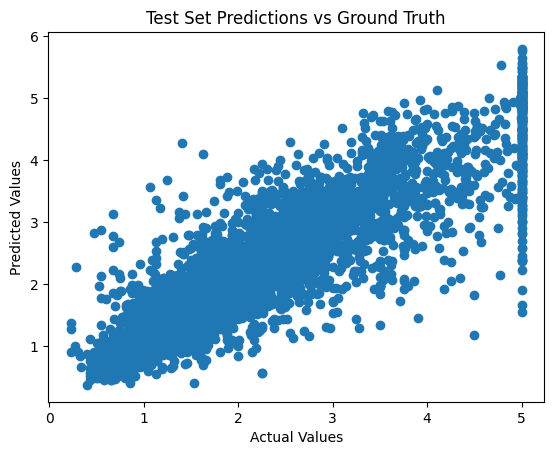

In [21]:
y_pred = final_model.predict(x_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set Predictions vs Ground Truth')
plt.show()

**Binary Classification**

Train the regression model to predict if home values are over or below $200,000 by modifying it for binary classification.

Alter output and loss function: In binary classification, the loss function is changed to binary cross-entropy, and the output layer contains a single unit with a sigmoid activation function.

In [28]:
def build_binary_classification_model(hidden_layers, hidden_units, input_shape):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_shape,)))

    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))

    # Output layer for binary classification (sigmoid activation)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


**Target variable to binary conversion:** Binary values are assigned to the target labels, y_train and y_test: If the price is less $200,000, it is 0, and if it is over, it is 1.

**Train and assess the binary classification model**: After training the model, I assess its accuracy using the test data.

In [29]:

# let recreate x_train to have the same number of samples as y_train_binary
from sklearn.model_selection import train_test_split

# Reshape y_train to 2D if necessary
y_train_2d = y_train.reshape(-1, 1) if y_train.ndim == 1 else y_train

# Split the data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    x_train, y_train_2d, test_size=0.4, random_state=42  # Adjust test_size as needed
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42  # Adjust test_size as needed
)
import numpy as np
# Now you can create the binary labels based on the updated y_train and y_test
y_train_binary = np.where(y_train < 2, 0, 1)
y_test_binary = np.where(y_test < 2, 0, 1)
y_val_binary = np.where(y_val < 2, 0, 1)  # Create binary labels for validation set


# Now, proceed with model training:
binary_model = build_binary_classification_model(2, 128, x_train.shape[1])
binary_model.fit(
    x_train,
    y_train_binary,
    validation_data=(x_val, y_val_binary),  # Use validation data with binary labels
    epochs=20,
    batch_size=32,
)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6919 - loss: 0.5986 - val_accuracy: 0.8000 - val_loss: 0.4424
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7815 - loss: 0.4498 - val_accuracy: 0.8187 - val_loss: 0.4063
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8116 - loss: 0.3887 - val_accuracy: 0.8206 - val_loss: 0.3796
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8333 - loss: 0.3694 - val_accuracy: 0.8318 - val_loss: 0.3709
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8123 - loss: 0.3586 - val_accuracy: 0.8393 - val_loss: 0.3622
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8412 - loss: 0.3414 - val_accuracy: 0.8393 - val_loss: 0.3615
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8541 - loss: 0.3217 - val_accuracy: 0.8542 - val_loss: 0.3565
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.3154 - val_accuracy: 0.8523 - val_loss

**Metrics**:

**Accuracy:** Whether the house price is over or under $200,000, the accuracy score shows how frequently the model's predictions match the actual labels.





